This time, we are facing a task that separate mixed sounds through probability theory. In the simple case, to separate $n$ sound sources, we have $n$ microphones at different position recording all received sound. And, we need to estimate all sound sources according to these mixed records. The basic idea we used here is assuming source sounds follow a specific distribution (prior), and we maximize likelihood of mixed sound records when given a mixing matrix to find the optimal mixing matrix. Then use it to calculate source sounds.

### Load Audios from Files

At first we need be able to load audio file into memory for calculation. Here, we use package **scipy**. You can install it through **pip**, if necessary.

In [187]:
from scipy.io import wavfile

srate, dataBach = wavfile.read('data/bach.wav')
_, dataSpeech = wavfile.read('data/speech.wav')

Currently, sound tracks is loaded as type of '*int16*', which is not convenient for calculation. We need to normalize them into range of $[-0.5, 0.5]$. Here, we create a function to do this.

In [188]:
import numpy as np

def audionorm(data):
    # ensure data is ndarray with float numbers
    data = np.asarray(data).astype('float')
    # calculate lower and upper bound
    lbound, ubound = np.min(data), np.max(data)
    if lbound == ubound:
        offset = lbound
        scalar = 1
        data = np.zeros(size=data.shape)
    else:
        offset = (lbound + ubound) / 2
        scalar = 1 / (ubound - lbound)
        data = (data - offset) * scalar
    # return normalized data
    return data

Then, we get all source sound tracks as a matrix, in which each sound track is a row:

In [189]:
gtruthS = audionorm([dataBach, dataSpeech])

### Make a simple Audio Mixer

Before, we actaully start to separate the sources blindly, it's necessary to compose mixed sound tracks at first. Here, we use following steps to implement it:
1. generate a random matrix (mixing matrix) with uniform distribution in range $[0,1]$
2. multiply mixing matrix with matrix of source sound tracks

In [190]:
def simpleMixer(S):
    nchannel = S.shape[0]
    # generate a random matrix
    A = np.random.uniform(size = (nchannel,nchannel))
    # generate mixed audio data
    X = A.dot(S)
    
    return X, A

As told in lecture, the $i$-th row of mixing matrix corresponds to weights of each source sound track in $i$-th sound mixture. While, each colomn of mixing matrix represends the bases of sound mixture. For illustration purpose, we create a plotting function to show mixture data point with axis (column vector of mixing matrix).

In [191]:
%matplotlib inline

import matplotlib.pyplot as plt

def drawDataWithMixingMatrix(data, mat):
    # plot data points
    plt.scatter(data[0], data[1], s=1)
    # calculate axis length
    lenAxis = np.sqrt(np.sum(np.square(mat), axis=0))
    # calculate scale for illustration
    scale = np.min(np.max(np.abs(data), axis=1) / lenAxis.T)
    # draw axis as arrow
    plt.arrow(0, 0, scale * mat[0,0], scale * mat[1,0], shape='full', color='r')
    plt.arrow(0, 0, scale * mat[0,1], scale * mat[1,1], shape='full', color='r')

Now, we get our mixed sound tracks with ground truth of mixing matrix, and plot them to see it visually. You should play with it to get more sense about what mixing matrix is. And this would help you to understand and implement the algorithm in this assignment.

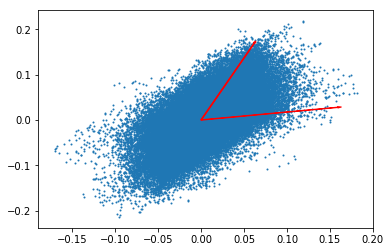

In [192]:
X, gtruthA = simpleMixer(gtruthS)
drawDataWithMixingMatrix(X, gtruthA)

Save them into files, and then you can hear them through your system's audio player.

In [193]:
wavfile.write('data/mixedTrackA.wav', srate, X[0])
wavfile.write('data/mixedTrackB.wav', srate, X[1])

### Build Up Optimization Functions

To separate source sound tracks, we need to optmize mixing matrix to maximize likelihood of sound mixtures with given mixing matrix. This time you have to implement this algorithm by yourself. If you want to run following part of demo directly, you should implement the function with name *bss* and return recovered sound tracks.

If you have no idea about how to start, here is some guideline:
1. initialize an identity matrix as your intial mixing matrix
2. calculate source sound tracks with current mixing matrix
3. calculate gradient of mixing matrix
4. update mixing matrix with its gradient multiply with a step size (if your method cannot converge, try a smaller step size)
5. go to step 2 until stop criteria fulfilled
6. calculate recovered source sound tracks with final mixing matrix
6. return mixing matrix and recovered source sound tracks

During the optimization, you should output some information to help you see the state of your algorithm. The way we used in our implementation is print current log-likelihood. A better way to do it is plotting the mixing matrix with mixture data with function we provide above.

Here, we just refer an external file, which we don't provide, to import function *bss*.

In [194]:
# BSS Function, essentially the ICA
def bss(data):
    matA = np.asarray([[1, 0],[0, 1]])
    I = np.asarray([[1, 0],[0, 1]])
    stepSize = .001
    S = np.zeros(data.shape)
    Z = np.zeros(data.shape)
    Aold = np.asarray([[1, 0],[0, 1]])
    i = 0
    while(True):
        i += 1
        if( i % 10 == 0):
            print("Iteration ", i)
            print(matA)        
        S = np.matmul(np.linalg.inv(matA), data)
        Z = - np.copy(S)
        #Z =  - (np.absolute(np.copy(S)))
        # dA = -A(zs^T + I)
        deltaA = - np.matmul(matA, ((np.matmul(Z,S.transpose())) + I))
        Aold = np.copy(matA)
        matA = matA + (deltaA * stepSize)
        Aconv = matA - Aold
        if (Aconv.sum() < .00001):
            print(i, " trials")
            break
    S = np.matmul(np.linalg.inv(matA), data)
    # matrix (A) first, data (S) second
    return matA, S

### Verify Implementation with Synthetic Data

Before actually apply this algorithm to sound data. It's a good habbit to check the implementation with synthetic data, and debug it if necessary. Here, we require you to write a function to generate synthetic mixture sound tracks with given mixing matrix. We use a function named *syntheticDataGenerate* from external file. It should return a matrix in size $2 \times n$, where $n$ is the quantity of data points specified in argument of function call. To implement this function, you should follow these two steps:
1. generate a $2 \times n$ matrix with random elements following standard Laplace distribution
2. use given mixing matrix with random matrix generate in first step compose the mixture

In [195]:
## Generate synthetic data
def syntheticDataGenerate(matA, nsamples):
    # 2 rows, nsamples columns, 
    synthData = np.zeros((2, nsamples))
    for x in range(2):
        for y in range(nsamples):
            synthData[x,y] = np.random.laplace()
    return np.matmul(matA, synthData)

In [196]:
# from bsslib import syntheticDataGenerate

# quantity of data points
nsamples = 10000
# specific mixing matrix (for illustration purpose)
verifyA = np.asarray([[1, 4],[2, 2]])
# generate synthetic data
synthData = syntheticDataGenerate(verifyA, nsamples)
# do optimization with bss function
#print(synthData)
estimateA, recoverData = bss(synthData)

Iteration  10
[[353.66594709 202.66678702]
 [202.66678702 170.51223873]]
Iteration  20
[[359.24339947 201.74383943]
 [201.74383943 176.92377586]]
Iteration  30
[[364.40818683 201.23151925]
 [201.23151925 182.5515564 ]]
Iteration  40
[[369.26229347 200.98145669]
 [200.98145669 187.63164918]]
Iteration  50
[[373.86409121 200.91223809]
 [200.91223809 192.29600104]]
Iteration  60
[[378.25139581 200.97374079]
 [200.97374079 196.62772451]]
Iteration  70
[[382.45080872 201.13270867]
 [201.13270867 200.68347522]]
Iteration  80
[[386.48217687 201.36588562]
 [201.36588562 204.50411707]]
Iteration  90
[[390.36097402 201.65636435]
 [201.65636435 208.12040324]]
Iteration  100
[[394.09968117 201.99148185]
 [201.99148185 211.55625853]]
Iteration  110
[[397.70863902 202.36152926]
 [202.36152926 214.83079772]]
Iteration  120
[[401.19660171 202.75892146]
 [202.75892146 217.95962976]]
Iteration  130
[[404.57111169 203.17764112]
 [203.17764112 220.95573508]]
Iteration  140
[[407.83876246 203.61285404]
 [2

Iteration  1210
[[527.5266003  230.3366929 ]
 [230.3366929  319.36708834]]
Iteration  1220
[[527.80227892 230.41207449]
 [230.41207449 319.57464324]]
Iteration  1230
[[528.07234442 230.48595849]
 [230.48595849 319.7779384 ]]
Iteration  1240
[[528.33691414 230.55837467]
 [230.55837467 319.97706429]]
Iteration  1250
[[528.59610287 230.62935216]
 [230.62935216 320.17210935]]
Iteration  1260
[[528.85002285 230.69891955]
 [230.69891955 320.36316001]]
Iteration  1270
[[529.0987839  230.76710485]
 [230.76710485 320.55030074]]
Iteration  1280
[[529.34249341 230.83393552]
 [230.83393552 320.73361415]]
Iteration  1290
[[529.58125644 230.89943847]
 [230.89943847 320.91318094]]
Iteration  1300
[[529.81517574 230.9636401 ]
 [230.9636401  321.08908006]]
Iteration  1310
[[530.04435187 231.02656626]
 [231.02656626 321.26138866]]
Iteration  1320
[[530.26888318 231.0882423 ]
 [231.0882423  321.43018219]]
Iteration  1330
[[530.48886589 231.14869307]
 [231.14869307 321.59553442]]
Iteration  1340
[[530.704

Iteration  2710
[[540.57659845 233.94568407]
 [233.94568407 329.15557471]]
Iteration  2720
[[540.5899355  233.94941326]
 [233.94941326 329.16554161]]
Iteration  2730
[[540.60300785 233.95306853]
 [233.95306853 329.17531063]]
Iteration  2740
[[540.61582077 233.95665132]
 [233.95665132 329.18488572]]
Iteration  2750
[[540.62837942 233.96016309]
 [233.96016309 329.19427071]]
Iteration  2760
[[540.64068884 233.96360524]
 [233.96360524 329.20346941]]
Iteration  2770
[[540.65275399 233.96697914]
 [233.96697914 329.2124855 ]]
Iteration  2780
[[540.66457972 233.97028616]
 [233.97028616 329.22132261]]
Iteration  2790
[[540.67617079 233.97352761]
 [233.97352761 329.22998432]]
Iteration  2800
[[540.68753186 233.97670481]
 [233.97670481 329.2384741 ]]
Iteration  2810
[[540.69866749 233.97981902]
 [233.97981902 329.24679537]]
Iteration  2820
[[540.70958218 233.98287149]
 [233.98287149 329.25495147]]
Iteration  2830
[[540.72028029 233.98586344]
 [233.98586344 329.2629457 ]]
Iteration  2840
[[540.730

Iteration  4210
[[541.21568312 234.12446969]
 [234.12446969 329.63308752]]
Iteration  4220
[[541.21634432 234.12465476]
 [234.12465476 329.63358147]]
Iteration  4230
[[541.21699242 234.12483616]
 [234.12483616 329.63406563]]
Iteration  4240
[[541.21762767 234.12501396]
 [234.12501396 329.63454019]]
Iteration  4250
[[541.21825032 234.12518824]
 [234.12518824 329.63500535]]
Iteration  4260
[[541.21886064 234.12535906]
 [234.12535906 329.63546129]]
Iteration  4270
[[541.21945886 234.1255265 ]
 [234.1255265  329.63590819]]
Iteration  4280
[[541.22004521 234.12569062]
 [234.12569062 329.63634623]]
Iteration  4290
[[541.22061995 234.12585149]
 [234.12585149 329.63677558]]
Iteration  4300
[[541.22118329 234.12600917]
 [234.12600917 329.63719643]]
Iteration  4310
[[541.22173547 234.12616373]
 [234.12616373 329.63760893]]
Iteration  4320
[[541.2222767  234.12631522]
 [234.12631522 329.63801326]]
Iteration  4330
[[541.22280721 234.1264637 ]
 [234.1264637  329.63840957]]
Iteration  4340
[[541.223

We can compare mixing matrix and recovered one by print them. It's simple and straight-forward. But, here we would use the plotting function above to compare them. We also create a function to make comparision more convenient. This methods is helpful when you get equivalent result but different in concrete numbers.

In [197]:
def compareMixingMatrix(data, matA, matB):
    plt.figure(figsize=(16, 8))
    # plot first mixing matrix
    plt.subplot(1,2,1)
    drawDataWithMixingMatrix(data, matA)
    # plot first mixing matrix
    plt.subplot(1,2,2)
    drawDataWithMixingMatrix(data, matB)

We can plot ground truth of mixing matrix and our estimation through optmization with function shown above.

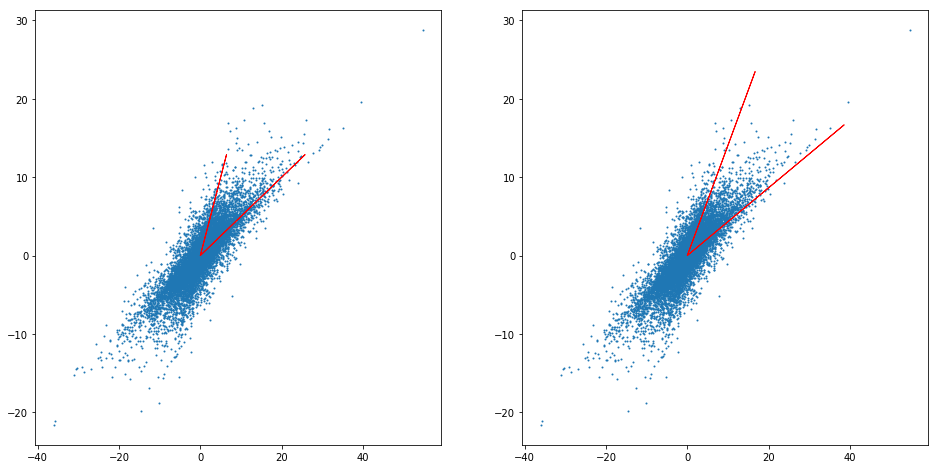

In [198]:
compareMixingMatrix(synthData, verifyA, estimateA)

We hope your implementation works well here.

### Apply ICA to Mixed Sound Tracks

Now, let's apply our algorithm to the mixed sound tracks to see what happend,

In [199]:
A, S = bss(X)

Iteration  10
[[1.74874843 0.5761172 ]
 [0.5761172  2.53163783]]
Iteration  20
[[2.26798999 0.87606358]
 [0.87606358 3.45847847]]
Iteration  30
[[2.67723766 1.09564813]
 [1.09564813 4.16612102]]
Iteration  40
[[3.0238313  1.27525003]
 [1.27525003 4.75677684]]
Iteration  50
[[3.32810766 1.42972427]
 [1.42972427 5.27096924]]
Iteration  60
[[3.601148   1.56647523]
 [1.56647523 5.72984135]]
Iteration  70
[[3.8498148  1.68982469]
 [1.68982469 6.14612854]]
Iteration  80
[[4.0787215  1.80255702]
 [1.80255702 6.52822792]]
Iteration  90
[[4.29115384 1.90659235]
 [1.90659235 6.88203456]]
Iteration  100
[[4.48955466 2.00332265]
 [2.00332265 7.2118828 ]]
Iteration  110
[[4.67580163 2.09379622]
 [2.09379622 7.5210749 ]]
Iteration  120
[[4.85137698 2.17882681]
 [2.17882681 7.81219886]]
Iteration  130
[[5.0174765  2.25906173]
 [2.25906173 8.08733014]]
Iteration  140
[[5.17508264 2.33502643]
 [2.33502643 8.3481652 ]]
Iteration  150
[[5.32501501 2.4071548 ]
 [2.4071548  8.59611328]]
Iteration  160
[[5.

Iteration  1230
[[ 9.85632969  4.55505649]
 [ 4.55505649 16.04622551]]
Iteration  1240
[[ 9.86531428  4.55928323]
 [ 4.55928323 16.06095384]]
Iteration  1250
[[ 9.87411284  4.56342239]
 [ 4.56342239 16.07537712]]
Iteration  1260
[[ 9.88272938  4.56747585]
 [ 4.56747585 16.08950194]]
Iteration  1270
[[ 9.89116783  4.57144548]
 [ 4.57144548 16.10333475]]
Iteration  1280
[[ 9.89943203  4.57533308]
 [ 4.57533308 16.11688183]]
Iteration  1290
[[ 9.90752573  4.57914041]
 [ 4.57914041 16.13014932]]
Iteration  1300
[[ 9.91545257  4.5828692 ]
 [ 4.5828692  16.14314325]]
Iteration  1310
[[ 9.92321613  4.58652113]
 [ 4.58652113 16.15586945]]
Iteration  1320
[[ 9.93081992  4.59009786]
 [ 4.59009786 16.16833367]]
Iteration  1330
[[ 9.93826733  4.59360098]
 [ 4.59360098 16.1805415 ]]
Iteration  1340
[[ 9.9455617   4.59703208]
 [ 4.59703208 16.1924984 ]]
Iteration  1350
[[ 9.95270629  4.60039267]
 [ 4.60039267 16.20420973]]
Iteration  1360
[[ 9.95970428  4.60368428]
 [ 4.60368428 16.21568071]]
Iterat

Iteration  2420
[[10.25968196  4.7447462 ]
 [ 4.7447462  16.70734835]]
Iteration  2430
[[10.26047917  4.74512099]
 [ 4.74512099 16.70865485]]
Iteration  2440
[[10.26126051  4.74548832]
 [ 4.74548832 16.70993536]]
Iteration  2450
[[10.2620263   4.74584833]
 [ 4.74584833 16.71119039]]
Iteration  2460
[[10.26277687  4.74620119]
 [ 4.74620119 16.71242045]]
Iteration  2470
[[10.2635125   4.74654703]
 [ 4.74654703 16.71362604]]
Iteration  2480
[[10.2642335   4.74688599]
 [ 4.74688599 16.71480765]]
Iteration  2490
[[10.26494016  4.7472182 ]
 [ 4.7472182  16.71596576]]
Iteration  2500
[[10.26563276  4.74754381]
 [ 4.74754381 16.71710084]]
Iteration  2510
[[10.26631159  4.74786294]
 [ 4.74786294 16.71821334]]
Iteration  2520
[[10.26697692  4.74817573]
 [ 4.74817573 16.71930372]]
Iteration  2530
[[10.26762903  4.7484823 ]
 [ 4.7484823  16.72037242]]
Iteration  2540
[[10.26826817  4.74878277]
 [ 4.74878277 16.72141987]]
Iteration  2550
[[10.2688946   4.74907726]
 [ 4.74907726 16.72244649]]
Iterat

Iteration  3600
[[10.29605033  4.76184341]
 [ 4.76184341 16.76695022]]
Iteration  3610
[[10.29612516  4.76187859]
 [ 4.76187859 16.76707286]]
Iteration  3620
[[10.29619851  4.76191307]
 [ 4.76191307 16.76719306]]
Iteration  3630
[[10.29627041  4.76194686]
 [ 4.76194686 16.76731088]]
Iteration  3640
[[10.29634087  4.76197999]
 [ 4.76197999 16.76742637]]
Iteration  3650
[[10.29640994  4.76201246]
 [ 4.76201246 16.76753956]]
Iteration  3660
[[10.29647764  4.76204429]
 [ 4.76204429 16.76765051]]
Iteration  3670
[[10.296544    4.76207548]
 [ 4.76207548 16.76775926]]
Iteration  3680
[[10.29660905  4.76210606]
 [ 4.76210606 16.76786585]]
Iteration  3690
[[10.2966728   4.76213603]
 [ 4.76213603 16.76797033]]
Iteration  3700
[[10.29673529  4.7621654 ]
 [ 4.7621654  16.76807274]]
Iteration  3710
[[10.29679654  4.7621942 ]
 [ 4.7621942  16.76817312]]
Iteration  3720
[[10.29685657  4.76222242]
 [ 4.76222242 16.76827151]]
Iteration  3730
[[10.29691542  4.76225008]
 [ 4.76225008 16.76836794]]
Iterat

At first, let's save recoverd sound tracks to files and hear them with your ear. **One important thing, you should normalize recovered sound track before write into files. This is because the recovery may different to ground truth in scales**.

In [200]:
# normalized sound tracks
S = audionorm(S)
# write recovered sound track into WAV files
wavfile.write('data/separatedTrackA.wav', 22050, S[0])
wavfile.write('data/separatedTrackB.wav', 22050, S[1])

Not bad, right? Then, let's illustrate the result with function created above,

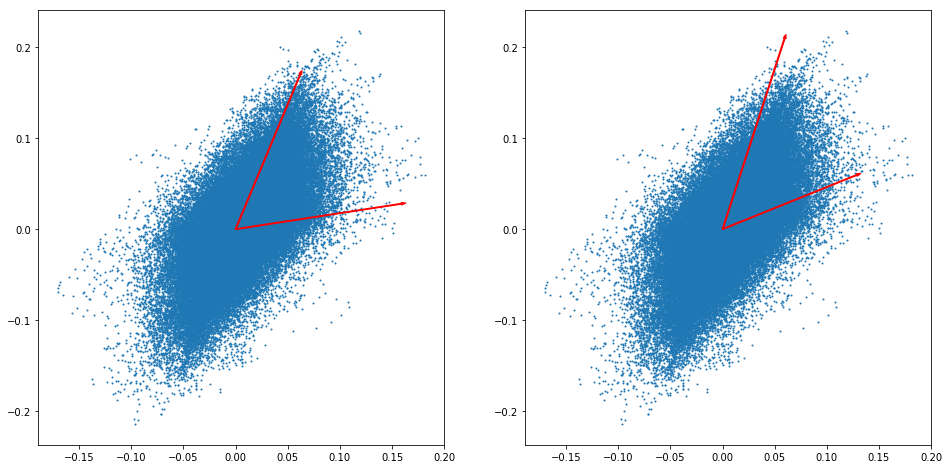

In [201]:
compareMixingMatrix(X, gtruthA, A)

They looks a little bit different in length, right? If you check the concrete number of two matrices, it would supprise you.

In [202]:
print('\nMixing Matrix (Our Estimation)\n\n', A)
print('\nMixing Matrix (Groud Truth)\n\n', gtruthA)


Mixing Matrix (Our Estimation)

 [[10.29843237  4.7629632 ]
 [ 4.7629632  16.77085395]]

Mixing Matrix (Groud Truth)

 [[0.15364203 0.39357216]
 [0.42119906 0.06901499]]


Not close, right? **Why? Does it mean probability theory don't work?** This is a problem we leave for you to think.

### Beyond the Demo

To answer above questions, you may need to do some exploration by yourself to understand this model in depth. If you have no clue where to start. We'll provide you some options:
- Draw histogram of source tracks to see whether or not it follows our assumption (Laplace distribution)
- Dig in depth of mathematical deduction of this Model, and try to understand the effect of each part

**All these suggestion are not necessary to be complete. You, of course, can do any exploration that interested you.**